In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [11]:
#使用3次多项式拟合OverallQual,SalePrice，得到系数
p_poly_val = np.polyfit(train['OverallQual'], train['SalePrice'], 3)
#drop SalePrice
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

## Imputation of missing values ##

array([  3.96466218e-03,   3.16048353e+01])

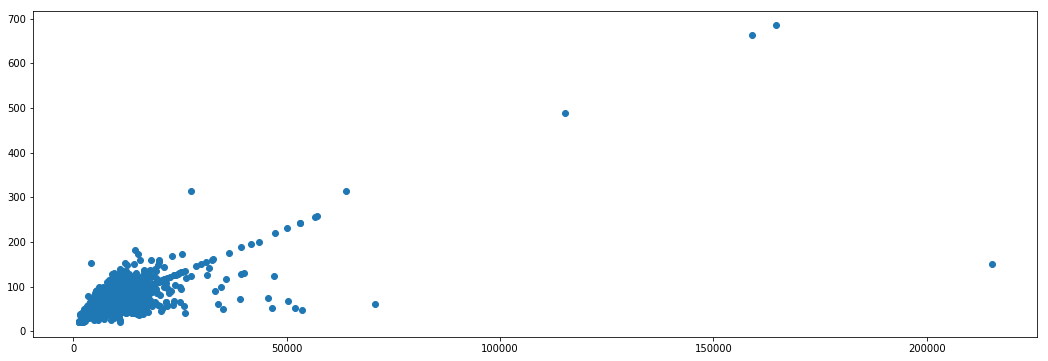

In [34]:
#warnings.simplefilter('ignore', np.RankWarning)
# I have no idea how to do it better. Probably, it is better to do nothing
#np.logical_not(all_data["LotFrontage"].isnull())LotFrontage非NaN的行。
#提取LotArea和LotFrontage非空的行，观察这两个变量的联系
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
#fig = plt.figure(figsize=(18,6))
#ax1 = fig.add_subplot(111)  
#ax1.scatter(x, y)

#离群值是不是画的范围太小？？
t = (x <= 25000) & (y <= 150)
#拟合非离群值的线性关系
p = np.polyfit(x[t], y[t], 1)
#根据拟合的关系，纠正数据
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

#实际效果看着变化不大
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data['LotFrontage'].isnull()), 'LotFrontage'] 
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(111)  
ax1.scatter(x, y)
p

There are many features were NaN should be considered as absence of such property. In other cases I replace NaN with most common value
NaN应该被视为缺乏这种属性的许多特征。 在其他情况下，我用最常见的价值取代NaN

In [35]:
all_data = all_data.fillna({
    'Alley' : 'NoAlley',
    'MasVnrType': 'None',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'BsmtQual' : 'NoBsmt',
    'BsmtCond' : 'NoBsmt',
    'BsmtExposure' : 'NoBsmt',
    'BsmtFinType1' : 'NoBsmt',
    'BsmtFinType2' : 'NoBsmt',
    'KitchenQual' : 'TA',
    'MSZoning' : 'RL',
    'Utilities' : 'AllPub',
    'Exterior1st' : 'VinylSd',
    'Exterior2nd'   : 'VinylSd',
    'Functional' : 'Typ',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'Electrical' : 'SBrkr'
     
})


all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0

# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

## Normalization ##

In [36]:
# where we have order we will use numeric
all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},
                             'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'Fence': {'GdPrv': 2, 
                                       'GdWo': 2, 
                                       'MnPrv': 1, 
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}                             
                            })

In [37]:
all_data = all_data.replace({'CentralAir': {'Y': 1, 
                                            'N': 0}})
all_data = all_data.replace({'PavedDrive': {'Y': 1, 
                                            'P': 0,
                                            'N': 0}})

newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

In [38]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

In [40]:
# The idea is good quality should rise price, poor quality - reduce price
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'


overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)

bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

# do smth with BsmtFinType1, BsmtFinType2

I have no idea what to do with Exterior1st, Exterior2nd, RoofMatl, Condition1, Condition2, BldgType. I'll try convert them into some kind of price brackets

我不知道如何处理Exterior1st，Exterior2nd，RoofMatl，Condition1，Condition2，BldgType。 我会尝试将它们转换成某种价格区间

In [43]:
from sklearn.svm import SVC
svm = SVC(C=100, gamma=0.0001, kernel='rbf')
# price categories
pc = pd.Series(np.zeros(train.shape[0]))
pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
X_t = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)
svm.fit(X_t, pc)
pc_pred = svm.predict(X_t)
pc_pred

array(['pc2', 'pc1', 'pc2', ..., 'pc1', 'pc1', 'pc1'], dtype=object)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

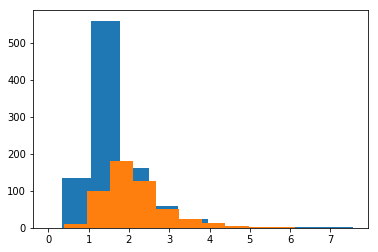

In [42]:
p = train.SalePrice/100000
plt.hist(p[pc_pred=='pc1'])
plt.hist(p[pc_pred=='pc2'])
plt.hist(p[pc_pred=='pc3'])

In [44]:
price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])
X_t = pd.get_dummies(all_data.loc[:, columns_for_pc], sparse=True)
pc_pred = svm.predict(X_t)
price_category[pc_pred=='pc2'] = 1
price_category[pc_pred=='pc3'] = 2
price_category = price_category.to_sparse()

In [46]:
# Monthes with the lagest number of deals may be significant
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

# Numer month is not significant
all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

In [53]:
#all_data = all_data.replace({'CentralAir': {'Y': 1, 
#                                            'N': 0}})
#all_data = all_data.replace({'PavedDrive': {'Y': 1, 
 #                                           'P': 0,
#                                           'N': 0}})

In [68]:
reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])
reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1
reconstruct = reconstruct.to_sparse()

recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])
recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1
recon_after_buy = recon_after_buy.to_sparse()

build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])
build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1
build_eq_buy = build_eq_buy.to_sparse()


In [69]:
# I hope this will help
all_data.YrSold = 2010 - all_data.YrSold

In [70]:
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'
year_map

1871    YearGroup1
1872    YearGroup1
1873    YearGroup1
1874    YearGroup1
1875    YearGroup1
1876    YearGroup1
1877    YearGroup1
1878    YearGroup1
1879    YearGroup1
1880    YearGroup1
1881    YearGroup1
1882    YearGroup1
1883    YearGroup1
1884    YearGroup1
1885    YearGroup1
1886    YearGroup1
1887    YearGroup1
1888    YearGroup1
1889    YearGroup1
1890    YearGroup1
1891    YearGroup2
1892    YearGroup2
1893    YearGroup2
1894    YearGroup2
1895    YearGroup2
1896    YearGroup2
1897    YearGroup2
1898    YearGroup2
1899    YearGroup2
1900    YearGroup2
           ...    
1981    YearGroup6
1982    YearGroup6
1983    YearGroup6
1984    YearGroup6
1985    YearGroup6
1986    YearGroup6
1987    YearGroup6
1988    YearGroup6
1989    YearGroup6
1990    YearGroup6
1991    YearGroup7
1992    YearGroup7
1993    YearGroup7
1994    YearGroup7
1995    YearGroup7
1996    YearGroup7
1997    YearGroup7
1998    YearGroup7
1999    YearGroup7
2000    YearGroup7
2001    YearGroup7
2002    Year

In [71]:
all_data.YearBuilt = all_data.YearBuilt.map(year_map)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

#### Scaling numeric data

In [72]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
t = all_data[numeric_feats].quantile(.75)
use_75_scater = t[t != 0].index
all_data[use_75_scater] = all_data[use_75_scater]/all_data[use_75_scater].quantile(.75)

In [73]:
t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

## Preparing for sklearn##

In [75]:
# all classes in sklearn requires numeric data only
# transform categorical variable into binary
#X = pd.get_dummies(all_data, sparse=True)
X = pd.get_dummies(all_data)
X = X.fillna(X.median())
#X = X.fillna(0)
print(X.shape)
all_data.fillna(all_data.median())

X["IsRegularLotShape"] = (all_data["LotShape"] == "Reg") * 1
X["IsLandLevel"] = (all_data["LandContour"] == "Lvl") * 1
#创建特征，将对应选项置为1
print(X["IsLandLevel"].head())
# Most land slopes are gentle; treat the others as "not gentle".
X["IsLandSlopeGentle"] = (all_data["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
X["IsElectricalSBrkr"] = (all_data["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
X["IsGarageDetached"] = (all_data["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
#X["IsPavedDrive"] = (all_data["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
X["HasShed"] = (all_data["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
X["Remodeled"] = (all_data["YearRemodAdd"] != all_data["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
X["RecentRemodel"] = (all_data["YearRemodAdd"] == all_data["YrSold"]) * 1
    
# Was this house sold in the year it was built?
X["VeryNewHouse"] = (all_data["YearBuilt"] == all_data["YrSold"]) * 1



X["Has2ndFloor"] = (all_data["2ndFlrSF"] == 0) * 1
X["HasMasVnr"] = (all_data["MasVnrArea"] == 0) * 1
X["HasWoodDeck"] = (all_data["WoodDeckSF"] == 0) * 1
X["HasOpenPorch"] = (all_data["OpenPorchSF"] == 0) * 1
X["HasEnclosedPorch"] = (all_data["EnclosedPorch"] == 0) * 1
X["Has3SsnPorch"] = (all_data["3SsnPorch"] == 0) * 1
X["HasScreenPorch"] = (all_data["ScreenPorch"] == 0) * 1

(2919, 291)
0    1
1    1
2    1
3    1
4    1
Name: IsLandLevel, dtype: int32


In [76]:
X = X.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
X = X.drop('Condition2_PosN', axis=1) # only two is not zero
X = X.drop('MSZoning_C (all)', axis=1)
X = X.drop('MSSubClass_SubClass_160', axis=1)

# this features definitely couse overfitting

drop_cols = [
                "Exterior1st_ImStucc", "Exterior1st_Stone",
                "Exterior2nd_Other","HouseStyle_2.5Fin", 
            
                "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll",
                "Condition2_RRAe", "Condition2_RRAn", "Condition2_RRNn",
                "Heating_Floor", "Heating_OthW",

                "Electrical_Mix", 
                "MiscFeature_TenC",
                #"GarageQual_Ex", 
                "PoolQC_Fa"
            ]
#X.drop(drop_cols, axis=1, inplace=True)

In [78]:
# add new features
X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,
               qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

#fK1 = pd.DataFrame(np.zeros((all_data.shape[0],1), dtype=float), columns=['fK1'])
##fK1 = all_data.1stFlrSF - all_data.GrLivArea
##fK1 = all_data.GrLivArea_KitchenQual - all_data.GrLivArea
#fK1 = all_data.KitchenQual
#fK1 = fK1.to_sparse()

#X = pd.concat((X, fK1), axis = 1)
X.shape

(2919, 351)

Next step is guess what new feachers we need to intoduse to make the model better. I'll make a lot of feachers and model will choose

In [79]:
from itertools import product, chain

def poly(X):
    areas = ['LotArea',  'GrLivArea' ,'TotalBsmtSF', 'GarageArea', 'BsmtUnfSF']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual',
               'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x
        
def poly1(X):
    areas = ['LotArea',  'GrLivArea' 
            , 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'WoodDeckSF', 'OpenPorchSF'
             , 'LowQualFinSF', 'PoolArea'
            ]#,'TotalBsmtSF']
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
            #   'BsmtCond', 
            #   'GarageQual', 'GarageCond',
               'KitchenQual',
               'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x
        
def polyGarage(X):
    areas = ['GarageArea']
    t = chain(qu_list.axes[1].get_values(), 
              ['GarageQual', 'GarageCond'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x
        
def polyBmst(X):
    areas = [ 'BsmtUnfSF', 'TotalBsmtSF']
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 
               'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x
        

def polyCat(X):
    areas = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond',
             'GarageQual', 'GarageCond',
               'KitchenQual',
               #'HeatingQC', 
               'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'
            , 'CentralAir', 'PavedDrive']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond',
               'GarageQual', 'GarageCond',
               'KitchenQual',
               #'HeatingQC',
               'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'
              , 'CentralAir', 'PavedDrive'])
    for a, t in product(areas, t):
        if a == t:
            continue
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_AND_' + t
        yield x
        
#XP = pd.concat(poly(X), axis=1)
#X = pd.concat((X, XP), axis=1)

XP = pd.concat(poly(X), axis=1)
X = pd.concat((X, XP), axis=1)
#XP = pd.concat(polyGarage(X), axis=1)
#X = pd.concat((X, XP), axis=1)
#XP = pd.concat(polyBmst(X), axis=1)
#X = pd.concat((X, XP), axis=1)
#XP = pd.concat(polyCat(X), axis=1)
#X = pd.concat((X, XP), axis=1)

In [80]:
#X = X.drop('BsmtUnfSF_GarageCond', axis = 1)

X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [81]:
# the model has become really big
X_train.shape

(1460, 506)

In [82]:
y = np.log1p(train.SalePrice)

In [83]:
# this come from iterational model improvment. I was trying to understand why the model gives to the two points much better price
#x_plot = X_train.loc[X_train['SaleCondition_Partial']==1, 'GrLivArea']
#y_plot = y[X_train['SaleCondition_Partial']==1]
#plt.scatter(x_plot, y_plot)

In [84]:
outliers_id = np.array([524, 1299])

outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
X_train = X_train.drop(outliers_id)
y = y.drop(outliers_id)
# There are difinetly more outliers

print(len(X_train))

#y = y[X_train['1stFlrSF'] / X_train['GrLivArea'] > 1.1]
#X_train = X_train[X_train['1stFlrSF'] / X_train['GrLivArea'] > 1.1]


#y = y[X_train['GrLivArea'] / X_train['GrLivArea_KitchenQual'] > 1.3]
#tX_train = X_train[X_train['GrLivArea'] / X_train['GrLivArea_KitchenQual'] > 1.3]
#X_train = tX_train

print(len(X_train))
print(len(y))

1458
1458
1458


In [85]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     #return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())
        return np.sqrt((( (np.log1p(y_pred)- np.log1p(y)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer, cv = 20)).mean()
    #return (train_test_split(model, X, y, scoring=scorer, cv = 20)).mean()

C:\Users\MappingLab-lxy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Learning ##
The model is sparse with n_features > n_samples. Likely it's linear.  It is classic case to use the Lasso model

In [86]:
from sklearn.linear_model import ElasticNet

#pIdx = np.random.permutation(len(y)) 

#ratios = [0.4, 0.5,0.6,0.7,0.8,0.9,0.95,0.98, 1.0]
#alphas = [1e-4, 1.5e-4, 2e-4,  2.25e-4, 2.5e-4, 2.75e-4, 3e-4, 3.5e-4, 4e-4, 5e-4, 7e-4, 1e-3]
#cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train[pIdx], y[pIdx]) for alpha in alphas]
#pd.Series(cv_lasso, index = alphas).plot()

Choose alpha with better score

In [87]:
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.linear_model import RandomizedLasso
from sklearn.kernel_ridge import KernelRidge




#xtrain, xtest, ytrain, ytest = train_test_split(X_train, y, train_size = 0.8, random_state = 96)
xtrain = X_train
ytrain = y
xtest = X_train.copy()
ytest = y.copy()


xtrainC1 = xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1]
ytrainC1 = ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1]
xtrainC2 = xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] <= 1.1]
ytrainC2 = ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] <= 1.1]

#print(len(xtrainC1))
#print(len(xtrain))
#ytrainC1 = ytrainC1.append(ytrain)
#xtrainC1 = xtrainC1.append(xtrain)
#print(len(xtrainC1))
#for i in range(2):
#    ytrainC1 = ytrainC1.append(ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])
#    xtrainC1 = xtrainC1.append(xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])
#print(len(xtrainC1))
    
    
#ytrain = ytrain.append(ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])
#xtrain = xtrain.append(xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])
#ytrain = ytrain.append(ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])
#xtrain = xtrain.append(xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1])

print(len(xtest))
#ytrain = ytrain[xtrain['SaleType_New'] == True]
#xtrain = xtrain[xtrain['SaleType_New'] == True]
#ytest = ytest[xtest['SaleType_New'] == True]
#xtest = xtest[xtest['SaleType_New'] == True]
#ytest = ytest[y]

#MinY = min(xtrain['GrLivArea'])
#MaxY = max(xtrain['GrLivArea'])
#MidY = (MinY + MaxY) / 2
#ytrain = ytrain[xtrain['GrLivArea'] > MidY]
#xtrain = xtrain[xtrain['GrLivArea'] > MidY]
#ytest = ytest[xtest['GrLivArea'] > MidY]
#xtest = xtest[xtest['GrLivArea'] > MidY]

MinY = min(ytrain)
MaxY = max(ytrain)
print(MinY,MaxY)
MinY=10.54
MaxY=13.53
MidY = (MinY + MaxY) / 2
MidY1 = MinY + (MaxY - MinY) * 0.55
xtrainP = xtrain[ytrain > MidY]
ytrainP = ytrain[ytrain > MidY]
#xtrain = xtrain[ytrain > MidY]
#ytrain = ytrain[ytrain > MidY]
#xtest = xtest[ytest > MidY]
#ytest = ytest[ytest > MidY]

#print(min(ytrain), max(ytrain), min(ytest), max(ytest))

#model_lasso_P = Lasso(alpha=3e-4, max_iter=50000).fit(xtrainP, ytrainP)

#print(len(xtest))
#print(xtest['OverallQual'])

#initXT = xtrain
#initYT = ytrain
#ytrain = ytrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1]
#xtrain = xtrain[xtrain['1stFlrSF'] / xtrain['GrLivArea'] > 1.1]
#ytest = ytest[xtest['1stFlrSF'] / xtest['GrLivArea'] > 1.1]
#xtest = xtest[xtest['1stFlrSF'] / xtest['GrLivArea'] > 1.1]

#model_lasso = Lasso(alpha=5e-4, max_iter=50000).fit(X_train, y)

#xtLen = int(len(xtrain) * 0.995)
#xtLen1 = int(len(xtrain) * 0.005)
#xtrain_k1 = xtrain[:xtLen]
#ytrain_k1 = ytrain[:xtLen]
#xtrain_k2 = xtrain[xtLen1:]
#ytrain_k2 = ytrain[xtLen1:]

model_lasso = Lasso(alpha=3e-4, max_iter=50000).fit(xtrain, ytrain)
#model_lasso = ElasticNet(alpha=3e-4, max_iter=50000, l1_ratio= 0.6).fit(xtrain, ytrain)

#model_lasso = Lasso(alpha=2.5e-4, max_iter=50000).fit(xtrain, ytrain)
#model_lasso_1 = Lasso(alpha=2.8e-4, max_iter=50000).fit(xtrain_k1, ytrain_k1)
#model_lasso_2 = Lasso(alpha=3.1e-4, max_iter=50000).fit(xtrain_k2, ytrain_k2)

#model_lasso_1 = Lasso(alpha=2.6e-4, max_iter=50000, selection = 'random').fit(xtrain, ytrain)
#model_lasso_2 = Lasso(alpha=2.8e-4, max_iter=50000, selection = 'random').fit(xtrain, ytrain)
#model_lasso_3 = Lasso(alpha=3.15e-4, max_iter=50000, selection = 'random').fit(xtrain, ytrain)
#model_lasso_4 = Lasso(alpha=3.3e-4, max_iter=50000, selection = 'random').fit(xtrain, ytrain)
#model_lasso_5 = Lasso(alpha=1e-4, max_iter=50000).fit(xtrain, ytrain)
#model_lasso_6 = Lasso(alpha=5e-4, max_iter=50000).fit(xtrain, ytrain)

#model_lassoC1 = model_lasso
#model_lassoC1 = Lasso(alpha=3e-4, max_iter=50000).fit(xtrainC1, ytrainC1)
#model_lassoC2 = Lasso(alpha=6e-4, max_iter=50000).fit(xtrainC2, ytrainC2)

#model_lasso = RandomizedLasso(alpha=5e-4, max_iter=50000).fit(xtrain, ytrain)
#model_lasso = Lasso(alpha=4e-4, max_iter=50000).fit(xtrain, ytrain)
#model_lasso = Lasso(alpha=7.5e-4, max_iter=50000).fit(xtrain, ytrain)


#model_lasso = linear_model.LogisticRegression().fit(xtrain, ytrain)
#model_lasso = KernelRidge(alpha=5e-4).fit(xtrain, ytrain)

MinL = min(X_train['GrLivArea'])
MaxL = max(X_train['GrLivArea'])

print(len(xtrain))

#xtrain1 = list()
#xtrain2 = list()
#ytrain1 = list()
#ytrain2 = list()

#xtrain1 = np.array([])
#xtrain2 = np.array([])
#ytrain1 = np.array([])
#ytrain2 = np.array([])

#for i in range(len(xtrain)):
 #   if xtrain['GrLivArea'][i] < MinL + (MaxL - MinL) * 0.5:
#      np.append(xtrain1, xtrain[:][i])
   #     np.append(ytrain1, ytrain[:][i])
# else:
#        np.append(xtrain2, xtrain[:][i])
 #       np.append(ytrain2, ytrain[:][i])
        
#print(len(xtrain1))
#print(len(xtrain2))
        
#print(len(xtrain['GrLivArea']  > MinL + (MaxL - MinL) * 0.5))

#model_lasso1 = Lasso(alpha=5e-4, max_iter=50000).fit(xtrain, ytrain)

#x_plot = X_train.loc[:, 'GrLivArea_KitchenQual']
#y_plot = X_train.loc[:, 'GrLivArea']
##y_plot = X_train.loc[:, '1stFlrSF']
#plt.scatter(x_plot, y_plot)

AttributeError: 'BlockManager' object has no attribute 'T'

## Getting results##

In [88]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns).sort_values()
#imp_coef = pd.concat([coef.head(10), coef.tail(10)])
#imp_coef.plot(kind = "barh")
#plt.title("Coefficients in the Model")
imp_coef = pd.concat([coef.head(23)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model         Up")


NameError: name 'model_lasso' is not defined

Some features still look suspicious. May be, we need to exlude them like RoofMatl_ClyTile and others

In [ ]:
imp_coef = pd.concat([coef.tail(23)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model         Down")

# This is a good way to see how model predict data
import xgboost
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from numpy import inf

import warnings
warnings.filterwarnings('ignore')

#ELASTIC NET
clf2 = ElasticNet(alpha=0.0005, l1_ratio=0.9)
clf2.fit(xtrain, ytrain)
elas_preds = np.expm1(clf2.predict(xtrain))

#XGBOOST
clf3=xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0.045,                 
                 learning_rate=0.07,
                 max_depth=20,
                 min_child_weight=1.5,
                 n_estimators=3000,                                                                    
                 reg_alpha=0.65,
                 reg_lambda=0.45,
                 subsample=0.95)

clf3.fit(xtrain, ytrain)
xgb_preds = np.expm1(clf3.predict(xtrain))



#p_pred = np.expm1(model_lasso.predict(xtrain))
p_pred = (np.expm1(model_lasso.predict(xtrain)) 
          #+ np.expm1(model_lasso_1.predict(xtrain)) + np.expm1(model_lasso_2.predict(xtrain))
          #+ np.expm1(model_lasso_3.predict(xtrain)) + np.expm1(model_lasso_4.predict(xtrain))
         # + np.expm1(model_lasso_5.predict(xtrain)) + np.expm1(model_lasso_6.predict(xtrain))
          ) / 1

lasso_preds = p_pred

WK1 = 0.51
WK2 = 0.24
WK3 = 0.26

#WK1 = 0.57
#WK2 = 0.21
#WK3 = 0.23

p_pred = WK1*lasso_preds + WK2*xgb_preds+WK3*elas_preds

#MinY = min(p_pred)
#MaxY = max(p_pred)
#MidY = (MinY + MaxY) / 2
#xtrainP = xtrain[p_pred < MidY]
#ytrainP = ytrain[p_pred < MidY]
#print(len(xtrain))
#rint(len(xtrainP))
#xtest = xtest[ytest > MidY]
#ytest = ytest[ytest > MidY]

#idx = 0
#for index, it in xtrain.iterrows():
#    if ytrain[index].item() > np.expm1(MidY):
#    #if p_pred[idx] > np.expm1(MidY):
#    #if p_pred[idx] > MidY:
#        p_pred[idx] = np.expm1(model_lasso_P.predict(it))
#    idx = idx + 1


#idx = 0
#for index, it in xtrain.iterrows():
#    if it['1stFlrSF'] / it['GrLivArea'] > 1.1:
#        p_pred[idx] = np.expm1(model_lassoC1.predict(it))
#    else:
#        p_pred[idx] = np.expm1(model_lasso.predict(it))
#    idx = idx + 1

resid = np.expm1(ytrain) - p_pred

X_train_new = X_train
#X_train_new['GrLivArea']=0

clf = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features = 0.9,
                               max_depth = 9, min_samples_split = 25, min_samples_leaf = 10,
 random_state = 36
                          )

#clfC1 = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features = 0.9,
 #                              max_depth = 9, min_samples_split = 25, min_samples_leaf = 10,
# random_state = 36
 #                         )

#clf = MLPRegressor(hidden_layer_sizes = (50, 30), solver = 'adam', random_state = 35,
#                   alpha = 0.0001, max_iter = 500, activation = 'logistic',
 #                 learning_rate_init = 0.001, batch_size = 40)

#clf = ExtraTreesRegressor(n_estimators=500, max_depth = 6 ,# max_features = 0.5,
 #                          min_samples_split = 25, min_samples_leaf = 10,
#random_state = 36
 #                        )

#clf = xgboost.XGBRegressor(n_estimators=10, max_depth = 8, colsample_bytree = 0.5,
##clf = xgboost.XGBRegressor(n_estimators=100, max_depth = 5, colsample_bytree = 0.5,
 #                          min_child_weight = 20, gamma = 0.5, subsample = 0.96,
#                     #reg_lambda = 0.9, reg_alpha = 0.8, missing = 0,
  #                seed = 36)
    
#clf = SVR(kernel='rbf', C=0.5)

#resid1 = resid[xtrain['OverallQual'] < 1.25]
#xtrain1 = xtrain[xtrain['OverallQual'] < 1.25]

#xtrain_SY = xtrain.copy()
#xtrain_SY["s1Y"] = np.log1p(p_pred)

clf.fit(xtrain, resid) 
#clf.fit(xtrain1, resid1) 
print("End train")

new_pred = clf.predict(xtrain_SY) + p_pred




#s1_test_pred = np.expm1(model_lasso.predict(xtest))
s1_test_pred = (np.expm1(model_lasso.predict(xtest)) 
               # + np.expm1(model_lasso_1.predict(xtest)) + np.expm1(model_lasso_2.predict(xtest))
               # + np.expm1(model_lasso_3.predict(xtest)) + np.expm1(model_lasso_4.predict(xtest))
               # + np.expm1(model_lasso_5.predict(xtest)) + np.expm1(model_lasso_6.predict(xtest)) 
               ) / 1

#idx = 0
#for index, it in xtest.iterrows():
#    if s1_test_pred[idx] > np.expm1(MidY1):
##   if ytest[index].item() > MidY:
#        s1_test_pred[idx] = np.expm1(model_lasso_P.predict(it))
#    idx = idx + 1

#s1_test_pred = np.median( [np.expm1(model_lasso.predict(xtest)),
 #               np.expm1(model_lasso_1.predict(xtest)),
#              np.expm1(model_lasso_2.predict(xtest)),
#               np.expm1(model_lasso_3.predict(xtest)),
 #              np.expm1(model_lasso_4.predict(xtest)) ])

#idx = 0
#for index, it in xtest.iterrows():
#    if it['1stFlrSF'] / it['GrLivArea'] > 1.1:
#        s1_test_pred[idx] = np.expm1(model_lassoC1.predict(it))
#    else:
#        s1_test_pred[idx] = np.expm1(model_lasso.predict(it))
#    idx = idx + 1

elas_preds = np.expm1(clf2.predict(xtest))
xgb_preds = np.expm1(clf3.predict(xtest))
lasso_preds = s1_test_pred
s1_test_pred = WK1*lasso_preds + WK2*xgb_preds+WK3*elas_preds



#xtest["s1Y"] = np.log1p(s1_test_pred)



test_pred = s1_test_pred + clf.predict(xtest)

print("Stage 1 score")
print(rmsle(np.expm1(ytest), s1_test_pred))

#idx = 0
#for index, it in xtest.iterrows():
#    if test_pred[idx] > np.expm1(MidY1):
#        s1_test_pred[idx] = np.expm1(model_lasso_P.predict(it))
#        test_pred[idx] = np.expm1(model_lasso_P.predict(it)) + clf.predict(it)
#    idx = idx + 1

#lenTest = len(ytest)
#ytest = ytest[int(lenTest/2):]
#test_pred = test_pred[int(lenTest/2):]
#s1_test_pred = s1_test_pred[int(lenTest/2):]

#print(len(xtest))
#print(len(test_pred))
#print(len(s1_test_pred))

#xtest.reindex_axis()
#print(xtest)
#print()
#print(ytest)

#for it in test_pred:
#    if it < min(np.expm1(ytrain)):
#        it = min(np.expm1(ytrain))

print(max(np.expm1(ytrain)), max(s1_test_pred))
print(min(np.expm1(ytrain)), min(s1_test_pred))

#test_pred[xtest['1stFlrSF'] / xtest['GrLivArea'] < 1.1] = s1_test_pred[xtest['1stFlrSF'] / xtest['GrLivArea'] < 1.1] + clf.predict(xtest[xtest['1stFlrSF'] / xtest['GrLivArea'] < 1.1])
print("new Lasso")

up_resid = np.expm1(ytrain) - new_pred 

#clf1 = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features = 0.9,
 #                              max_depth = 5, min_samples_split = 25, min_samples_leaf = 10,
#random_state = 51
 #                         )   

#clf1 = xgboost.XGBRegressor(n_estimators=10, max_depth = 7, colsample_bytree = 0.5,
##clf = xgboost.XGBRegressor(n_estimators=100, max_depth = 5, colsample_bytree = 0.5,
 #                          min_child_weight = 20, gamma = 0.5, subsample = 0.96,
#                   #reg_lambda = 0.9, reg_alpha = 0.8, missing = 0,
  #                seed = 36)

#clf1 = MLPRegressor(hidden_layer_sizes = (50, 30), solver = 'adam', random_state = 35,
  #                 alpha = 0.0001, max_iter = 500, activation = 'logistic',
#               learning_rate_init = 0.001, batch_size = 40)
    
#clf1 = MLPRegressor(hidden_layer_sizes = (40, 20), solver = 'adam', random_state = 35,
 #                  alpha = 0.001, max_iter = 300, activation = 'logistic')
    
#clf1.fit(xtrain, up_resid)
#test_pred = test_pred + clf1.predict(xtest)


#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
idx = 0
for index, it in xtest.iterrows():
    if it['OverallQual'] == 1.25:
        test_pred[idx] = s1_test_pred[idx]
    idx = idx + 1


#model_lasso_up = Lasso(alpha=1e-2, max_iter=200000).fit(xtrain, np.log1p(up_resid))
#test_pred = test_pred + np.expm1(model_lasso_up.predict(xtest))

#model_lasso_up = Lasso(alpha=1e-3, max_iter=200000).fit(xtrain, up_resid)
#test_pred = test_pred + model_lasso_up.predict(xtest)


#features = X_train.columns
#imp = clf.feature_importances_
#fimp = np.argsort(imp)
#fimp = fimp[-16:]
#plt.title('Feature Importances')
#plt.barh(range(len(fimp)), imp[fimp], color='b', align='center')
#plt.yticks(range(len(fimp)), features[fimp])
#plt.xlabel('Relative Importance')


tp = test_pred[xtest['1stFlrSF'] / xtest['GrLivArea'] < 1.1]

#plt.scatter(new_pred, np.expm1(y))
#plt.plot([min(new_pred),max(new_pred)], [min(new_pred),max(new_pred)], c="red")


print("Stage 1 score")
print(rmsle(np.expm1(ytest), s1_test_pred))
#print(rmsle(np.expm1(y), p_pred))
print("Stage 2 score")
print(rmsle(np.expm1(ytest), test_pred))

if(rmsle(np.expm1(ytest), test_pred) < rmsle(np.expm1(ytest), s1_test_pred)):
    print("============== OK =================")
#print(rmsle(np.expm1(y), new_pred))

Some point are far from the red line. May be they are outliers like the 524th and the 1299th

In [ ]:
# save to file to make a submission
ps1 = (np.expm1(model_lasso.predict(X_test)) 
   #  + np.expm1(model_lasso_1.predict(X_test)) + np.expm1(model_lasso_2.predict(X_test))
   #  + np.expm1(model_lasso_3.predict(X_test)) + np.expm1(model_lasso_4.predict(X_test))
     #+ np.expm1(model_lasso_5.predict(X_test)) + np.expm1(model_lasso_6.predict(X_test))
    ) / 1

elas_preds = np.expm1(clf2.predict(X_test))
xgb_preds = np.expm1(clf3.predict(X_test))
lasso_preds = ps1

ps1 = WK1*lasso_preds + WK2*xgb_preds+WK3*elas_preds

#idx = 0
#for index, it in X_test.iterrows():
#    if it['1stFlrSF'] / it['GrLivArea'] > 1.1:
#        ps1[idx] = np.expm1(model_lassoC1.predict(it))
#    else:
#        ps1[idx] = np.expm1(model_lasso.predict(it))
#    idx = idx + 1

#X_test["s1Y"] = ps1

p = ps1 + clf.predict(X_test)# + clf1.predict(X_test)

idx = 0
for index, it in X_test.iterrows():
    if it['OverallQual'] == 1.25:
        p[idx] = ps1[idx]
    idx = idx + 1

#solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution = pd.DataFrame({"id":p, "SalePrice":test.Id}, columns=['SalePrice', 'id'])
solution.to_csv("lasso_sol22_Median.csv", index = False)
print("Write Solution")


#p_pred = np.expm1(model_lasso.predict(xtrain))
p_pred = (np.expm1(model_lasso.predict(xtrain)) 
          #+ np.expm1(model_lasso_1.predict(xtrain)) + np.expm1(model_lasso_2.predict(xtrain))
          #+ np.expm1(model_lasso_3.predict(xtrain)) + np.expm1(model_lasso_4.predict(xtrain))
         # + np.expm1(model_lasso_5.predict(xtrain)) + np.expm1(model_lasso_6.predict(xtrain))
          ) / 1

lasso_pred = p_pred

## Model improvement##
With various model tunnings I've got 0.11720 in public leaderboard. Ways of improvement are find some more outliers and exlude (or include) features.